In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dask import delayed
from math import sqrt
import dask.array as da
import h5py, time
import dask.dataframe as dd
import dask.bag as db
import json

In [2]:
final = pd.read_csv('telco_data.csv')

In [3]:
final.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Examining object memory usage

In [4]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [5]:
final.memory_usage() // 1024

Index                0
customerID          55
gender              55
SeniorCitizen       55
Partner             55
Dependents          55
tenure              55
PhoneService        55
MultipleLines       55
InternetService     55
OnlineSecurity      55
OnlineBackup        55
DeviceProtection    55
TechSupport         55
StreamingTV         55
StreamingMovies     55
Contract            55
PaperlessBilling    55
PaymentMethod       55
MonthlyCharges      55
TotalCharges        55
Churn               55
dtype: int64

## Reading a df in chunks

In [6]:
def filter_for_var(data):
    ''' Returns a df filtering for a condition '''
    var_filter = (data.tenure >20)
    return data.loc[var_filter]

# list of dfs called chunks
chunks = []

# for-loop
#for chunk in pd.read_csv('telco_data.csv', chunksize=1000):
#    chunks.append(filter_for_var(chunk))
    
# list comprehension
chunks = [filter_for_var(chunk)
          for chunk in pd.read_csv('telco_data.csv', chunksize=1000)]


In [7]:
lengths = [len(chunk) for chunk in chunks]
lengths

[588, 595, 602, 559, 602, 584, 610, 25]

In [8]:
newdat = pd.concat(chunks)
newdat.shape

(4165, 21)

### Plot data

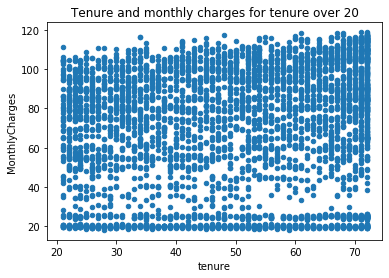

In [9]:
newdat.plot.scatter(x='tenure', y='MonthlyCharges')
plt.xlabel('tenure')
plt.ylabel('MonthlyCharges')
plt.title('Tenure and monthly charges for tenure over 20')
plt.show()

## Managing data with Generators
Very similar to list comprehension used above. But they use lazy evaluation. Elements are generated one at the time so they are never in memory simultaneously. This is helpful when operating at the limits of available memory. No reading or work is done until the very last step. 

In [10]:
chunks = (filter_for_var(chunk)
         for chunk in pd.read_csv('telco_data.csv', chunksize=1000))

charges = (chunk['MonthlyCharges'].sum() for chunk in chunks)

sum(charges)

291394.3

## Delaying computation with Dask

In [11]:
def f(z):
    return sqrt(z + 4)
def g(y):
    return y - 3
def h(x):
    return x**2

In [12]:
x = 4
y = h(x)
z = g(y)
w = f(z)
print(w)

4.123105625617661


Use a "delayed" from Dask. This is a higher-order (or a decorator) function that maps an input function to another modified output function. The result is a dask delayed object rather than a value, and the actual computation is only done when 'compute' is invoked.

In [13]:
y = delayed(h)(x)
z = delayed(g)(y)
w = delayed(h)(z)
print(w)
print(type(w))

Delayed('h-8dbe750d-404a-4430-84f3-a804e1552589')
<class 'dask.delayed.Delayed'>


In [14]:
w.compute()

169

### Deferring computation within loops

In [15]:
@delayed
def increment(x):
    return x + 1

@delayed
def double(x):
    return 2 * x

@delayed
def add(x, y):
    return x + y


In [16]:
data = [1, 2, 3, 4, 5]
output = []

for x in data:
    a = increment(x)
    b = double(x)
    c = add(a, b)
    output.append(c)
    
total = sum(output)    

The result is that total is a delayed object, output is a list of intermediate delayed objects, and total_sum is the final sum, where calculation is delayed until the very end. 

In [17]:
total

Delayed('add-9c236032390ebbad48ca373088dab764')

In [18]:
output

[Delayed('add-e7f61ef1-9c04-4538-8b3b-1f5e2bda6dfc'),
 Delayed('add-e853e057-5f5a-44cd-b236-4e61ff65b541'),
 Delayed('add-e8956ea8-3d77-4796-a5d9-d74cab073d8d'),
 Delayed('add-d3ef6b9d-84e8-4f75-a7f2-b22171f33c38'),
 Delayed('add-9f6b9a99-8424-487b-98b0-929b81fee632')]

In [19]:
total_sum = total.compute()
print(total_sum)

50


## Using a dask pipeline with delayed

Below is a slightly modified version of the functions used before. Again, no calculations are done until the very end when compute is called. 

In [20]:
# Define count_cases
@delayed
def count_cases(df):
    return len(df)

# Define count_female
@delayed
def count_female(df):
    return (df['gender']=='Female').sum()

# Define pct_females
@delayed
def pct_females(n_females, n_cases):
    return round(100 * sum(n_females) / sum(n_cases), 2)

In [21]:
n_cases = []
n_females = []

for chunk in pd.read_csv('telco_data.csv', chunksize=1000):
    n_cases.append(count_cases(chunk))
    n_females.append(count_female(chunk))
    
result = pct_females(n_females, n_cases)

In [22]:
print(type(result))
print(result.compute())

<class 'dask.delayed.Delayed'>
49.52


## Dask arrays

In [23]:
a = np.random.rand(10000)

In [24]:
a_dask = da.from_array(a, chunks=len(a) // 4) # chunks elements in each peace of a
print(a_dask.chunks)

((2500, 2500, 2500, 2500),)


In [25]:
n_chunks = 4
chunk_size = len(a) // n_chunks
result = 0 # accumulate sum

for k in range(n_chunks):
    offset = k * chunk_size # track offset
    a_chunk = a[offset:offset + chunk_size] # slice chunk
    result += a_chunk.sum()

Dask version of the above

In [26]:
a_dask = da.from_array(a, chunks = len(a) // n_chunks)
result = a_dask.sum()
result

dask.array<sum-aggregate, shape=(), dtype=float64, chunksize=()>

In [27]:
print(result.compute())

5052.0004119943005


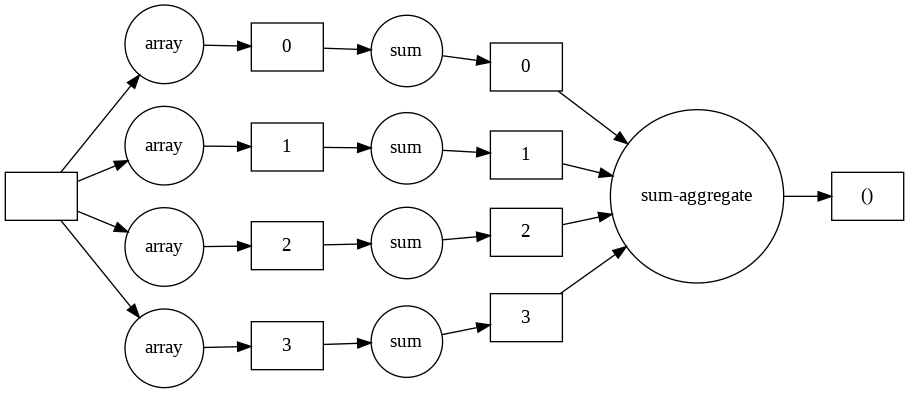

In [28]:
result.visualize(rankdir='LR') # forces horizontal layout

## Analysing weather data
The data is ub HDF5 format, which is a hierarchical data format for storing and managing data

In [29]:
data_store = h5py.File('2014-01-31.hdf5')

In [30]:
data_store

<HDF5 file "2014-01-31.hdf5" (mode r)>

In [31]:
for key in data_store.keys():
    print(key)

t2m


## Extracting dask array from HDF5

In [32]:
data = data_store['t2m'] # bind data for introspection
type(data)

h5py._hl.dataset.Dataset

In [33]:
data.shape 

(180, 360)

In [34]:
df = pd.DataFrame(data)

In [35]:
df

,0,1,2,3,4,5,6,7,8,9,...,350,351,352,353,354,355,356,357,358,359
0,109.50,110.25,110.25,110.25,110.25,110.25,110.25,110.25,110.25,110.25,...,109.50,109.50,109.50,109.50,109.50,109.50,109.50,109.50,109.50,109.50
1,110.75,110.75,110.75,110.75,110.75,110.75,110.75,110.75,110.75,110.75,...,111.25,111.25,111.25,110.75,110.75,110.75,110.75,110.75,110.75,110.75
2,111.75,111.75,111.75,111.75,111.25,111.25,111.25,111.25,111.25,111.25,...,111.75,111.75,111.75,112.50,112.50,111.75,111.75,111.75,111.75,111.75
3,113.25,112.75,112.75,112.75,113.50,113.50,114.00,114.00,113.50,113.50,...,112.25,112.25,112.25,113.25,113.25,112.25,112.25,113.25,113.25,113.25
4,116.00,115.50,115.50,115.50,115.50,115.50,115.50,115.50,115.50,115.00,...,115.00,115.00,115.00,115.00,115.50,115.00,115.00,115.50,115.50,115.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,61.75,61.75,61.75,61.75,61.75,61.75,60.25,60.25,60.25,60.25,...,64.25,63.25,63.25,62.75,62.75,62.75,62.25,62.25,61.25,61.25
176,60.25,60.25,60.25,60.25,60.75,60.75,59.75,59.75,59.75,59.75,...,61.75,62.25,62.25,61.25,61.25,61.75,60.75,60.75,60.75,61.25
177,59.25,59.25,59.25,58.25,58.25,58.25,58.25,58.25,58.25,58.75,...,60.25,60.25,59.75,59.75,59.75,58.75,58.75,58.75,58.75,58.75
178,57.25,57.25,57.25,57.25,57.25,57.25,57.25,57.25,57.75,57.75,...,58.25,58.25,58.25,58.25,58.25,57.25,57.25,57.25,57.25,57.25


In [36]:
data_dask = da.from_array(data, chunks=(180, 360))

In [37]:
data_dask.min()

dask.array<amin-aggregate, shape=(), dtype=float64, chunksize=()>

In [38]:
data_dask.min().compute()

1.25

If there are missing values in the data, use nanmin

In [39]:
da.nanmin(data_dask).compute()

1.25

In [40]:
da.nanmax(data_dask).compute()

236.75

## Stacking data

In [41]:
filenames = ['2014-01-30.hdf5', '2014-01-31.hdf5', '2014-01-29.hdf5', '2014-01-28.hdf5']

In [42]:
# List comprehension to read each file: dsets
dsets = [h5py.File(f)['/t2m'] for f in filenames]

In [43]:
# List comprehension to make dask arrays
dat = [da.from_array(d, chunks=(180,360)) for d in dsets]

In [44]:
# Stack with the list of dask arrays: by_year
new = da.stack(dat, axis=0)

In [45]:
new

dask.array<stack, shape=(4, 180, 360), dtype=float64, chunksize=(1, 180, 360)>

In [46]:
# Print the shape of the stacked arrays
print(new.shape)

(4, 180, 360)


## Dask dataframes
Lazy evaluation -doesn't read file immidiately, and files need not fit in memory.
Accepts single file name as usual or glob - pattern (with wildcard *)

In [47]:
#create some test data 
a = pd.read_excel('titanic_full.xlsx', sep=',')
a[0:300].to_csv('dask_titanic_test1.csv')
a[301:600].to_csv('dask_titanic_test2.csv')
a[601:900].to_csv('dask_titanic_test3.csv')

In [48]:
# this single line reads both train and test titanic files
titanic = dd.read_csv('dask_titanic_test*.csv', sep=',')

In [49]:
# This does not require compute, most others do though
titanic.head()

,Unnamed: 0,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0,0,0,24160,211.3375,B5,S,"St Louis, MO"
1,1,1,1,"Allison, Master. Hudson Trevor",male,NaN,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON"
2,2,1,0,"Allison, Miss. Helen Loraine",female,2.0,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON"
3,3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON"
4,4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON"


In [50]:
titanic['embarked'].describe().compute()

unique      3
count     896
top         S
freq      635
Name: embarked, dtype: object

Filter the dataframe as usual

In [51]:
is_male = (titanic['sex'] == 'male')
embarked_S = (titanic['embarked'] == 'S')

is_male_fare = titanic.loc[is_male & embarked_S, 'fare']

In [52]:
is_male_fare

Dask Series Structure:
npartitions=3
    float64
        ...
        ...
        ...
Name: fare, dtype: float64
Dask Name: loc-series, 27 tasks

In [53]:
male_fare_sum = is_male_fare.sum()

In [54]:
male_fare_sum.compute() # lazy evaluation

3402613.329

Since in this case the dataset consists of 3 files, we can confirm that there are 3 pipelines

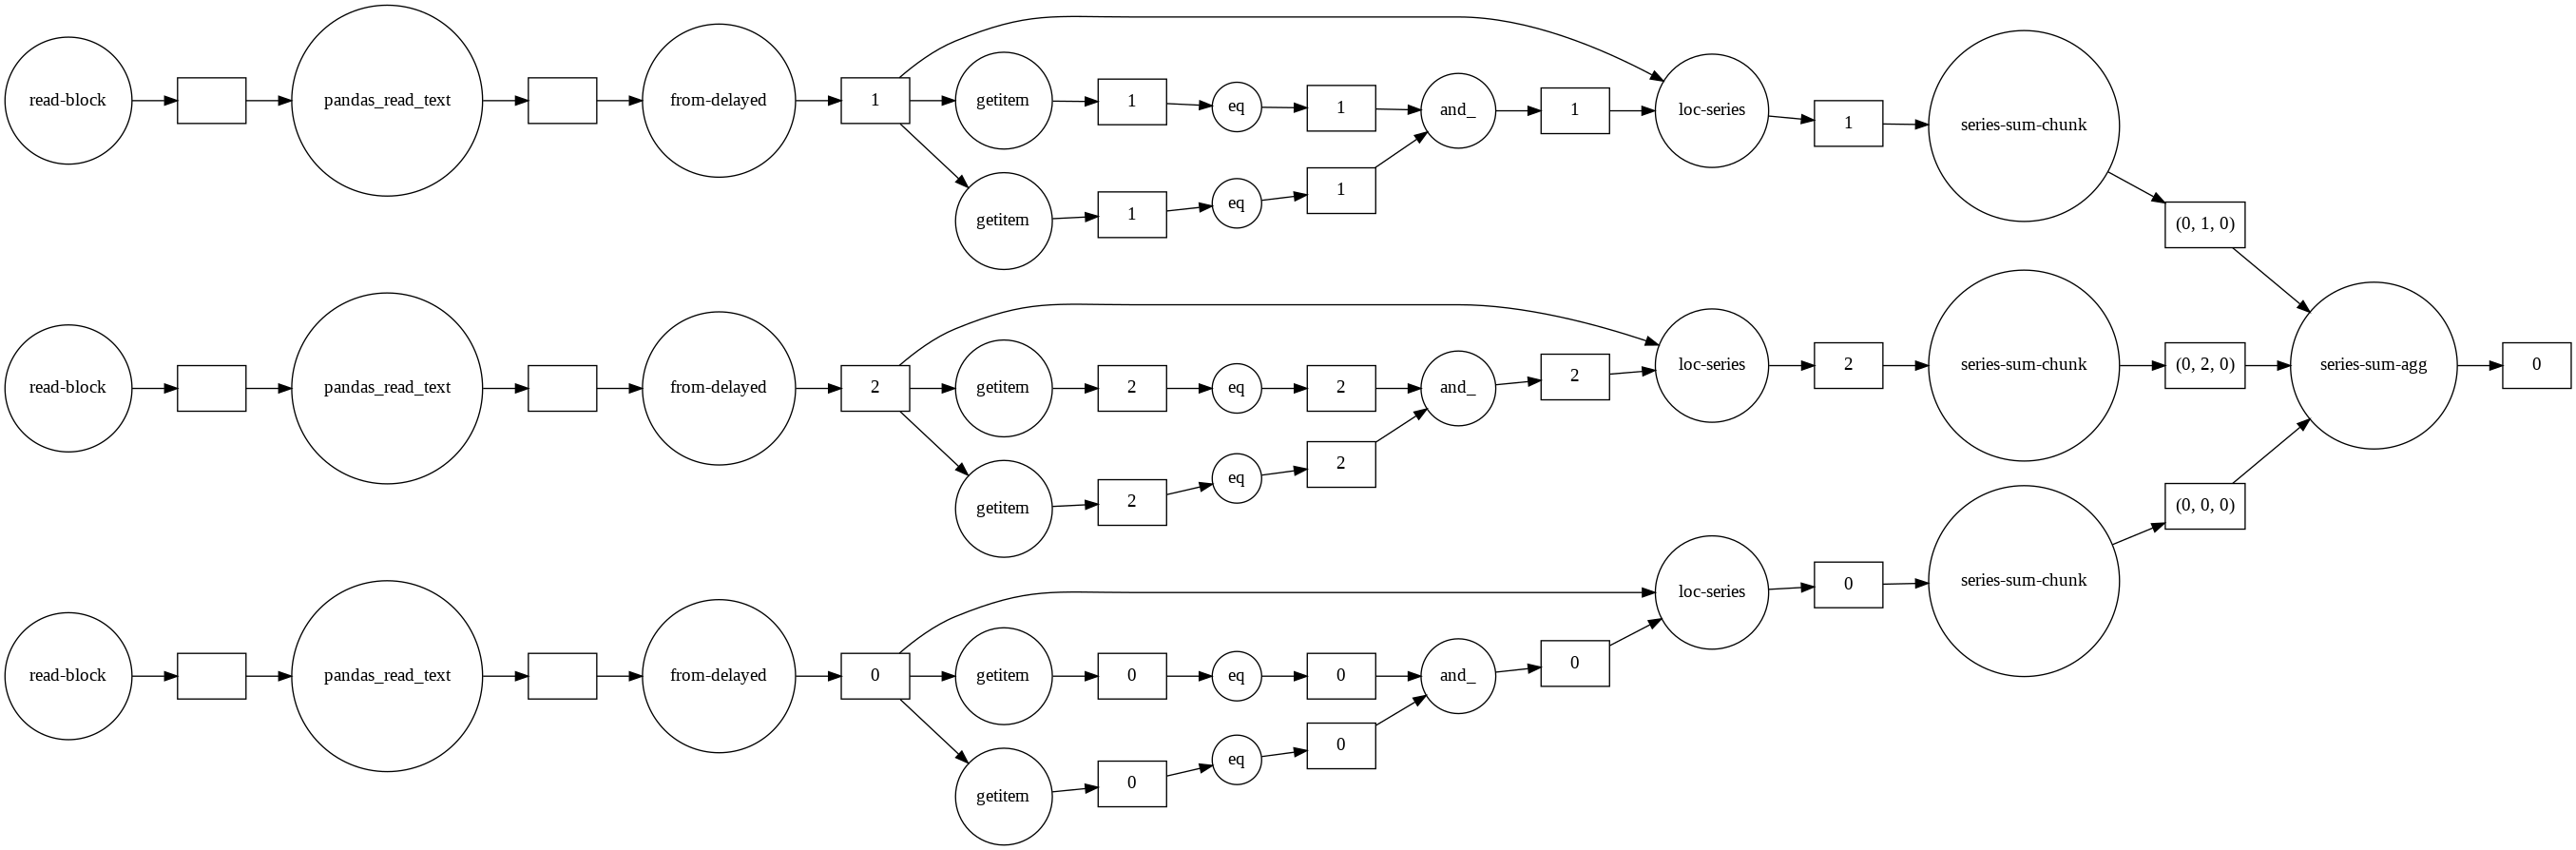

In [55]:
male_fare_sum.visualize(rankdir='LR')

Groupby and other relevant functions work exactly as in normal pandas

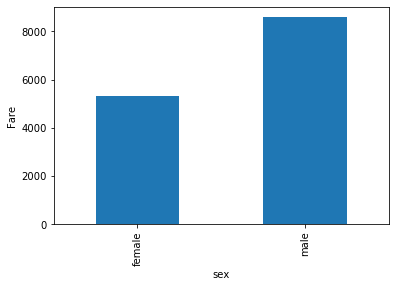

In [56]:
# Grouby filtered by the 'Year' column: yearly
yearly = titanic.groupby('sex')

# Calculate the mean of yearly: yearly_mean
yearly_mean = yearly.mean()

# Call .compute() to perform the computation: result
result = yearly_mean.compute()

# Plot the 'value' column with .plot.line()
result['fare'].plot.bar()
plt.ylabel('Fare')
plt.show()

## Timing Dask operations 

In [57]:
# Define a function with df as input
def myfunc(df):

    is_male = (df['sex'] == 'male')
    embarked_S = (df['embarked'] == 'S')

    df1 = df.loc[is_male & embarked_S]
    df2 = df1.groupby('sex')
    
    return df2['fare'].mean()

In [58]:
# Call time.time()
t0 = time.time()

# Read into df
df = pd.read_csv('dask_titanic_test1.csv')

# Group df by region: result
result = myfunc(df)

# Call time.time()
t1 = time.time()

# Print the execution time
print((t1-t0)*1000)

8.30984115600586


In [59]:
# Time the execution with Pandas and print in milliseconds
df = pd.read_csv('dask_titanic_test1.csv')
t0 = time.time()
result = myfunc(df)
t1 = time.time()
print((t1-t0)*1000)

3.8313865661621094


We can see that if the data set can be read into memory with pandas it is likely going to be faster than Dask, which needs to read the file chunkwise throughout the pipeline and does not cache intermediates in memory.

In [60]:
# Time the execution of dd.read_csv and myfunc together with 'dask_titanic_test1.csv' and print in milliseconds
t0 = time.time()
df = dd.read_csv('dask_titanic_test1.csv')
result = myfunc(df).compute()
t1 = time.time()
print((t1-t0)*1000)

62.719106674194336


## analysing New York Taxi data

In [61]:
df = pd.read_csv('yellow_tripdata_2019-01.csv')

In [62]:
df.shape

(7667792, 18)

In [63]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,N,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95,NaN
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,N,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30,NaN
2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,1,N,236,236,1,4.5,0.5,0.5,0.00,0.0,0.3,5.80,NaN
3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,1,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,7.55,NaN
4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,2,N,193,193,2,52.0,0.0,0.5,0.00,0.0,0.3,55.55,NaN


In [64]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge'],
      dtype='object')

In [65]:
df['payment_type'].value_counts()

1    5486027
2    2137415
3      33186
4      11164
Name: payment_type, dtype: int64

### Read the separate data files using Dask

In [66]:
df = dd.read_csv('yellow_tripdata_*.csv')

In [67]:
# Make column 'tip_fraction'
df['tip_fraction'] = df['tip_amount'] / (df['total_amount'] - df['tip_amount'])

# Convert 'tpep_dropoff_datetime' column to datetime objects
df['tpep_dropoff_datetime'] = dd.to_datetime(df['tpep_dropoff_datetime'])

# Construct column 'hour'
df['hour'] = df['tpep_dropoff_datetime'].dt.hour

## Dask bags

Ways of working with unstructured data

In [68]:
nested_containers = [[0,1,2,3], {}, 
                    [6.5, 3.14], 'Python',
                    {'version':3}]

In [69]:
the_bag = db.from_sequence(nested_containers)

In [70]:
the_bag.count() # nr of elements
the_bag.count().compute()

5

In [71]:
f = open('zen_of_python.txt', 'r')
x = f.readlines()
f.close()
x

['Beautiful is better than ugly.\n',
 'Explicit is better than implicit.\n',
 'Simple is better than complex.\n',
 'Complex is better than complicated.\n',
 'Flat is better than nested.\n',
 'Sparse is better than dense.\n',
 'Readability counts.\n',
 "Special cases aren't special enough to break the rules.\n",
 'Although practicality beats purity.\n',
 'Errors should never pass silently.\n',
 'Unless explicitly silenced.\n',
 'In the face of ambiguity, refuse the temptation to guess.\n',
 'There should be one-- and preferably only one --obvious way to do it.\n',
 "Although that way may not be obvious at first unless you're Dutch.\n",
 'Now is better than never.\n',
 'Although never is often better than *right* now.\n',
 "If the implementation is hard to explain, it's a bad idea.\n",
 'If the implementation is easy to explain, it may be a good idea.\n',
 "Namespaces are one honking great idea -- let's do more of those!"]

In [72]:
zen = db.read_text('zen_of_python.txt')
zen

dask.bag<bag-fro..., npartitions=1>

In [73]:
taken = zen.take(1)
print(taken)
print(type(taken))

('Beautiful is better than ugly.\n',)
<class 'tuple'>


In [74]:
zen.count().compute()

19

In [75]:
zen.take(3)

('Beautiful is better than ugly.\n',
 'Explicit is better than implicit.\n',
 'Simple is better than complex.\n')

## Functional approaches to using Dask Bags

### Normal functions

In [76]:
# mapping
def squared(x):
    return x ** 2

squares = map(squared, [1, 2, 3, 4, 5, 6])
squares

In [77]:
list(squares)

[1, 4, 9, 16, 25, 36]

In [78]:
# using filter
def is_even(x):
    return x % 2 == 0
evens = filter(is_even, [1, 2, 3, 4, 5, 6])
list(evens)

[2, 4, 6]

### Same in Dask

In [79]:
numbs = db.from_sequence([1, 2, 3, 4, 5, 6])
squares = numbs.map(squared)
squares

dask.bag<squared..., npartitions=6>

In [80]:
squares.compute()

[1, 4, 9, 16, 25, 36]

In [81]:
evens = numbs.filter(is_even)
evens.compute()

[2, 4, 6]

In [82]:
# Above combined
even_squares = numbs.map(squared).filter(is_even)
even_squares.compute()

[4, 16, 36]

## Splitting by word & count

In [89]:
# Call .str.split(' ') from speeches and assign it to by_word
by_word = zen.str.split(' ')

# Map the len function over by_word and compute its mean
n_words = by_word.map(len)
avg_words = n_words.mean()

# Print the type of avg_words and value of avg_words.compute()
print(type(avg_words))
print(avg_words.compute())

<class 'dask.bag.core.Item'>
7.2105263157894735


How many times is the phrase "is better than" mentioned in a text?

In [96]:
# Convert speeches to lower case: lower
lower = zen.str.lower()

# Filter lower for the presence of 'health care': health
health = lower.filter(lambda s:'is better than' in s)

# Count the number of entries : n_health
n_health = health.count()

# Compute and print the value of n_health
print(n_health.compute())

7


### Analysing Postcodes in json format

In [98]:
with open('postcodes.json') as f:
    items = json.load(f)
type(items)    

list

In [99]:
items[0]

{'ad_area_code': 'FI1D1',
 'postcode_fi_name': 'HEINÄVESI',
 'municipal_code': '090',
 'postcode_abbr_sv': '',
 'ad_area_fi': 'Etelä-Savo',
 'municipal_name_sv': 'Heinävesi',
 'ad_area_sv': 'Södra Savolax',
 'valid_from': '19881101',
 'type_code': '1',
 'postcode_abbr_fi': '',
 'date': '20190205',
 'municipal_name_fi': 'Heinävesi',
 'postcode': '79700',
 'municipal_language_ratio_code': '1',
 'postcode_sv_name': 'HEINÄVESI'}

In [100]:
items[1]

{'ad_area_code': 'FI1D6',
 'postcode_fi_name': 'PYHÄNKOSKI',
 'municipal_code': '483',
 'postcode_abbr_sv': '',
 'ad_area_fi': 'Pohjois-Pohjanmaa',
 'municipal_name_sv': 'Merijärvi',
 'ad_area_sv': 'Norra Österbotten',
 'valid_from': '19860101',
 'type_code': '1',
 'postcode_abbr_fi': '',
 'date': '20190205',
 'municipal_name_fi': 'Merijärvi',
 'postcode': '86240',
 'municipal_language_ratio_code': '1',
 'postcode_sv_name': 'PYHÄNKOSKI'}

In [102]:
items[1]['ad_area_code']

'FI1D6'

JSON files into Dask Bags

In [103]:
items = db.read_text('postcodes.json')

In [107]:
#items.take(1)

In [110]:
dict_items = items.map(json.loads) # converts strings -> other data
dict_items

dask.bag<loads-5..., npartitions=1>

In [114]:
#dict_items.take(1)

# Putting everything together

Use Dask dataframes for flights data

In [144]:
# Define @delayed-function read_flights
@delayed
def read_flights(filename):

    # Read in the DataFrame: df
    df = pd.read_csv(filename)

    df['FL_TIME'] = pd.to_datetime(df['YEAR'].astype(str) + 
                               df['MONTH'].astype(str) + 
                               df['DAY'].astype(str), format='%Y%m%d')
    
    # Replace 0s in df['WEATHER_DELAY'] with np.nan
    df['WEATHER_DELAY'] = df['WEATHER_DELAY'].replace(0, np.nan)

    # Return df
    return df

Reading all flight data. Iterate over the list filenames and to use the function read_flights to build a list of delayed objects. Finally, concatenate them into a Dask DataFrame with dd.from_delayed() and print out the mean of the WEATHER_DELAY column.

In [154]:
filenames = ['flightdelays-2015-1.csv', 'flightdelays-2015-2.csv', 'flightdelays-2015-3.csv']

# Loop over filenames with index filename
for filename in filenames:
    # Apply read_flights to filename; append to dataframes
    dataframes = dataframes.append(read_flights(filename))

# Compute flight delays: flight_delays
flight_delays = dd.from_delayed(dataframes)

# Print average of 'WEATHER_DELAY' column of flight_delays
%time print(flight_delays['WEATHER_DELAY'].mean().compute())

64.08333333333333
CPU times: user 150 ms, sys: 0 ns, total: 150 ms
Wall time: 148 ms


In [155]:
df = dd.read_csv('flightdelays*.csv')
%time print(df['WEATHER_DELAY'].mean().compute())

8.893557422969188
CPU times: user 60 ms, sys: 0 ns, total: 60 ms
Wall time: 58 ms
